## Federate data using Starburst & Python

### Prepare the environment

First run the following in your terminal. You can find more information about Python Virtual Environments in the [Python docs]("https://docs.python.org/3/library/venv.html").

*Windows cmd.exe*

`C:\> python -m venv venv`

`C:\> venv\Scripts\activate.bat`

*MacOS/Linux bash/zsh*

`$ python -m venv venv`

`$ source venv/bin/activate`

### Sign up for a Galaxy account & setup the sample catalog

You'll need a [Starburst Galaxy]("https://www.starburst.io/platform/starburst-galaxy/start/") account.

In [35]:
# Install the library

%pip install https://starburstdata-downloads.s3.amazonaws.com/pystarburst/0.5.0/pystarburst-0.5.0-py3-none-any.whl
%pip install pandas matplotlib

  Using cached https://starburstdata-downloads.s3.amazonaws.com/pystarburst/0.5.0/pystarburst-0.5.0-py3-none-any.whl (121 kB)
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [36]:
# Define Connection Properties
# You can get the host and other information from the Partner Connect -> PyStarburst section in Galaxy

import getpass
from env import *

if PROPMPT_CREDS:
    host = input("Host name")
    username = input("User name")
    password = getpass.getpass("Password")
else:
    host = HOST
    username = USERNAME
    password = PASSWORD

In [37]:
# Import dependencies

from pystarburst import Session
from pystarburst import functions as f
from pystarburst.functions import col, lit

import trino

session_properties = {
    "host":host,
    "port": 443,
    # Needed for https secured clusters
    "http_scheme": "https",
    # Setup authentication through login or password or any other supported authentication methods
    # See docs: https://github.com/trinodb/trino-python-client#authentication-mechanisms
    "auth": trino.auth.BasicAuthentication(username, password)
}

session = Session.builder.configs(session_properties).create()

In [38]:
# Validate connectivity to the cluster

session.sql("select 1 as b").show()

-------
|"b"  |
-------
|1    |
-------



In [39]:
# Let's understand the data

# Data in data lake
df_dl_customer_360 = session.table("s3lakehouse.data_product_customer_360.customer_information")
print(df_dl_customer_360.schema)
df_dl_customer_360.show()

# Data On Prem
df_onprem_credit = session.table("sep_dataproducts.customer_360.customer_with_credit")
print(df_onprem_credit.schema)
df_onprem_credit.show()


StructType([StructField('custkey', StringType(), nullable=True), StructField('first_name', StringType(), nullable=True), StructField('last_name', StringType(), nullable=True), StructField('estimated_income', DoubleType(), nullable=True), StructField('country', StringType(), nullable=True)])
---------------------------------------------------------------------------
|"custkey"  |"first_name"  |"last_name"  |"estimated_income"  |"country"  |
---------------------------------------------------------------------------
|1000008    |Margaret      |Larson       |61472.0             |CA         |
|1000511    |Teresa        |Parsons      |407285.76           |CA         |
|1000510    |Veronica      |Munoz        |141964.03           |CA         |
|1000509    |Russell       |Bradshaw     |133107.88           |US         |
|1000508    |Vanessa       |Poole        |403040.32           |CA         |
|1000507    |Brian         |Bell         |172785.95           |CA         |
|1000506    |Thomas     

In [40]:


from datetime import datetime

# We can add arbitrary SQL expressions as needed
df_onprem_credit = df_onprem_credit.with_column("risk_appetite", f.sql_expr("replace(\"risk_appetite\", 'wild_west', 'very_low')"))
df_onprem_credit.show()

# Now let's join the two tables between the lake and on-prem
df_joined = df_onprem_credit.join(df_dl_customer_360, df_onprem_credit['custkey'] == df_dl_customer_360['custkey'])

df_joined.show()
# Let's do some basic aggergations

df_summary = df_joined\
    .filter(col("customer_segment") == "diamond" )\
    .group_by("state")\
    .count()\
    .sort(col("count"), ascending=False)\

df_summary.show()



---------------------------------------------------------------------------------------------------------------------
|"custkey"  |"state"  |"estimated_income"  |"customer_segment"  |"cc_number"          |"cc_type"  |"risk_appetite"  |
---------------------------------------------------------------------------------------------------------------------
|1000001    |NC       |51299.55            |gold                |xxxxxxxxxxx5167      |travel     |low              |
|1000002    |DC       |168586.71           |gold                |xxxxxxxxxxxx5071     |cashback   |very_low         |
|1000003    |VT       |253388.29           |platinum            |xxxxxxxx1615         |cashback   |high             |
|1000006    |OK       |100559.42           |silver              |xxxxxxxxxxxx2247     |basic      |medium           |
|1000010    |NC       |316279.09           |diamond             |xxxxxxxxxx5207       |basic      |low              |
|1000012    |SC       |205898.82           |platinum    

In [41]:
#
# Finally, let's write the table to our data lake
#

session.sql("CREATE SCHEMA IF NOT EXISTS s3lakehouse.pystarburst_federation").collect()

session.sql("DROP TABLE IF EXISTS s3lakehouse.pystarburst_federation.federation_sum").collect()

df_summary.write.save_as_table(
    "s3lakehouse.pystarburst_federation.federation_sum",
)

df_validation = session.table("s3lakehouse.pystarburst_federation.federation_sum").show()

---------------------
|"state"  |"count"  |
---------------------
|AZ       |2        |
|NY       |1        |
|VT       |2        |
|WY       |2        |
|WV       |4        |
|MO       |2        |
|ID       |1        |
|ND       |2        |
|TX       |1        |
|DC       |3        |
---------------------



In [42]:
#
# Now we can convert to pandas
#

import pandas as pd
import matplotlib.pyplot as plt

def to_pandas_df(pystarburst_df):
    return pd.DataFrame(pystarburst_df.collect())

df_validation_pd = to_pandas_df(session.table("s3lakehouse.pystarburst_federation.federation_sum"))
df_validation_pd = df_validation_pd.sort_values('count')

<Axes: ylabel='count'>

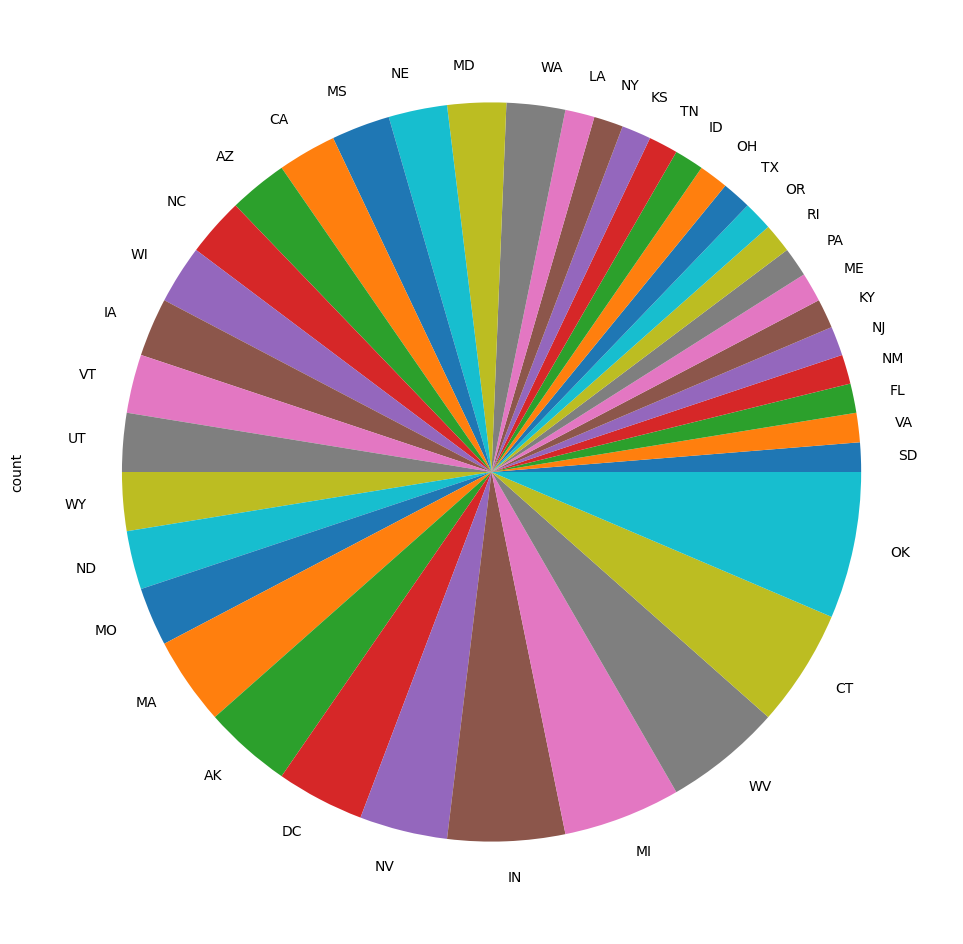

In [43]:
df_validation_pd.plot.pie(figsize=(20,12), y='count', labels=df_validation_pd['state'], legend=False)